In [1]:
from autocvd import autocvd
autocvd(num_gpus = 1)


import optimistix as optx
import jax.numpy as jnp
from jax import vmap
import jax.random as random

import odisseo

import matplotlib.pyplot as plt

# Inverse cdf interpolation


(0.0, 1.0)

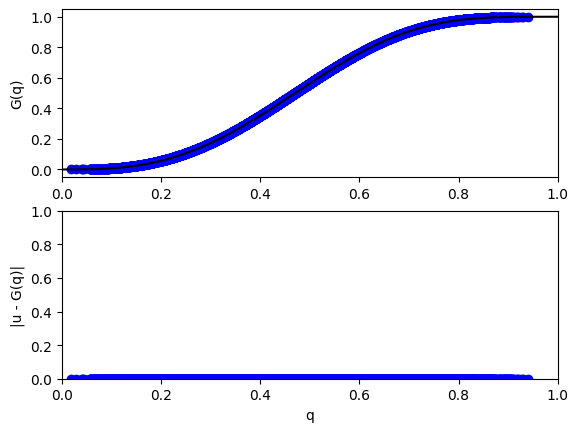

In [10]:
fig = plt.figure()

def G(x, ):
    # return 1287/16 * ((-2*(1-q)**(9/2))*(99*q**2+36*q+8)/1287 +16/1287) 
    norm = jnp.pi*7/512
    return 1/norm * (x*jnp.sqrt(1 - x**2)*(-384*x**8 + 1488*x**6 - 2104*x**4 + 1210*x**2 - 105) + 105*jnp.asin(x))/3840 
    # return (1-q**2)**(7/2) * q**2

q = jnp.linspace(0, 1, endpoint=True, num=100_000)
y = G(q, )
# y = y/jnp.sum(y)

ax = fig.add_subplot(211)
ax.plot(q, G(q), color='black')

u = random.uniform(key=random.PRNGKey(0), shape=(10_000,))
sample = jnp.interp(u, y, q)
ax.scatter(sample, u, color='blue')
ax.set_ylabel('G(q)')
ax.set_xlim(0, 1)

ax = fig.add_subplot(212)
ax.scatter(sample, abs(u-G(sample)), color='blue')
ax.set_xlabel('q')
ax.set_ylabel('|u - G(q)|')
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)

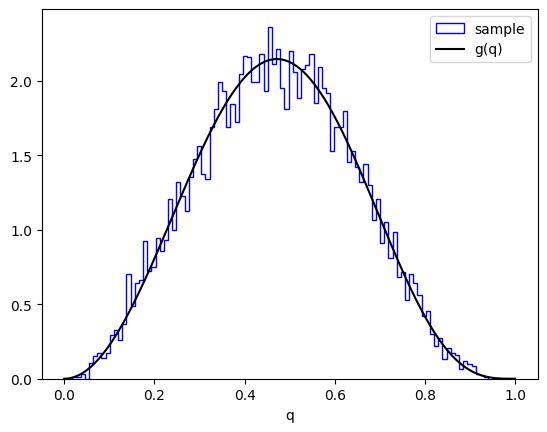

In [12]:
plt.hist(sample, histtype='step', color='blue',bins=100, density=True, label='sample')
q = jnp.linspace(0, 1, num=100_000)
norm = jnp.pi*7/512
y = (1/norm)*((1-q**2)**(7/2))*q**2 
plt.plot(q, y, color='black', label='g(q)')
plt.xlabel('q')
plt.legend()

# MCMC jaccpot

In [2]:
import jax
import jax.numpy as jnp
from jax import random, vmap, jit
from jax.nn import sigmoid

def soft_acceptance(df_vals, rand_vals, envelope_max, tau=0.01):
    """
    Computes a soft acceptance mask using a sigmoid function.

    Parameters:
      - df_vals: An array of DF values for each candidate.
      - rand_vals: An array of uniformly generated random values between 0 and 1.
      - envelope_max: The normalization factor used in the hard acceptance comparison.
      - tau: The temperature parameter controlling the softness of the transition (smaller values result in a harder transition).

    Returns:
      An array of values between 0 and 1 representing the "softness" of the acceptance, 
      where values close to 1 indicate high acceptance and values close to 0 indicate low acceptance.
    """
    return sigmoid((df_vals / envelope_max - rand_vals) / tau)

def sample_df_potential(key, params, n_candidates, envelope_max, tau=0.01):
    """
    Differentiable version of the sampling pipeline.
    
    Instead of a hard acceptance/rejection, returns weighted candidate actions.
    
    Parameters:
      - key: A JAX PRNGKey for random number generation.
      - params: Dictionary with DF parameters.
      - n_candidates: Number of candidate samples to generate.
      - envelope_max: Normalization factor.
      - tau: Temperature parameter for soft acceptance.
      
    Returns:
      A tuple (weighted_candidates, soft_weights):
        - weighted_candidates: Array of shape (n_candidates, 3) 
          where each candidate is multiplied by its soft acceptance weight.
        - soft_weights: Array of shape (n_candidates,) containing the acceptance weights.
    """
    key, subkey = random.split(key)
    
    
    candidates = jnp.stack([Jr_candidates, Jz_candidates, Lz_candidates], axis=1)
    
    #Evaluate the total DF for each candidate
    df_total_vec = jit(vmap(lambda cand: df_total_potential(cand[0], cand[1], cand[2], params)))
    df_vals = df_total_vec(candidates)
    
    #Generate uniform random numbers
    key, subkey = random.split(key)
    rand_vals = random.uniform(subkey, shape=(n_candidates,))
    
    #Compute the soft acceptance weights
    soft_weights = soft_acceptance(df_vals, rand_vals, envelope_max, tau)
    
    #here we multiply each candidate by its weight
    weighted_candidates = candidates * soft_weights[:, None]
    
    return weighted_candidates, soft_weights


def plummer_potential(r, G=1.0, M=1e5, a=1.0):
    return -G * M / jnp.sqrt(r**2 + a**2)

def plummer_df(v, r, G=1.0, M=1.0, a=1.0):
    phi = plummer_potential(r, G, M, a)
    E = phi - 0.5 * v**2
    return jnp.where(E > 0, v**2 * E**(3.5), 0.0)


# def sample_velocity() 


In [3]:
from astropy import units as u
from astropy import constants as c
from jax.nn import sigmoid



# from ott.tools.unreg import wassdis_p


import odisseo
from odisseo import construct_initial_state
from odisseo.integrators import leapfrog
from odisseo.dynamics import direct_acc, DIRECT_ACC, DIRECT_ACC_MATRIX, DIRECT_ACC_LAXMAP
from odisseo.option_classes import SimulationConfig, SimulationParams, MNParams, NFWParams, NFW_POTENTIAL, PlummerParams, MN_POTENTIAL, LogarithmicParams, LOGARITHMIC_POTENTIAL
from odisseo.initial_condition import Plummer_sphere, ic_two_body, sample_position_on_sphere, inclined_circular_velocity, sample_position_on_circle
from odisseo.utils import E_tot, Angular_momentum
from odisseo.time_integration import time_integration
from odisseo.units import CodeUnits
from odisseo.visualization import create_3d_gif, create_projection_gif, plot_last_snapshot, plot_sky_projection
from odisseo.potentials import MyamotoNagai, NFW


def soft_acceptance(x4, x5, tau=0.1):

    return sigmoid((0.1*x5 - x4) / tau)

code_length = 10.0 * u.kpc
code_mass = 1e5 * u.Msun
G = 1 
code_units = CodeUnits(code_length, code_mass, G=G)

config = SimulationConfig(N_particles=1_000_0000, 
                          return_snapshots=True, 
                          num_snapshots=100, 
                          num_timesteps=1000, 
                          external_accelerations=(LOGARITHMIC_POTENTIAL,), 
                          acceleration_scheme= DIRECT_ACC_MATRIX,
                          softening=(0.01* u.pc).to(code_units.code_length).value) #default values

params = SimulationParams(t_end = (10* u.Gyr).to(code_units.code_time).value,  
                          Plummer_params= PlummerParams(Mtot=(2.5*1e5 * u.Msun).to(code_units.code_mass).value,
                                                        a=(8 * u.pc).to(code_units.code_length).value),          
                          G=G, ) 

key = random.PRNGKey(0)
Plummer_Mtot = params.Plummer_params.Mtot
key_r, key_phi, key_sin_i, key_u, key_phi_v, key_sin_i_v= random.split(key, 6)
r = jnp.sqrt( params.Plummer_params.a**2 / (random.uniform(key=key_r, shape=(config.N_particles,))**(-2/3) -1))
phi = random.uniform(key=key_phi, shape=(config.N_particles,), minval=0, maxval=2*jnp.pi) 
sin_i = random.uniform(key=key_sin_i, shape=(config.N_particles,), minval=-1, maxval=1)

positions = jnp.array([r*jnp.cos(jnp.arcsin(sin_i))*jnp.cos(phi),
                        r*jnp.cos(jnp.arcsin(sin_i))*jnp.sin(phi), 
                        r*sin_i]).T
potential = - params.G * Plummer_Mtot / jnp.sqrt( jnp.linalg.norm(positions, axis=1)**2 + params.Plummer_params.a**2)
velocities_escape = jnp.sqrt(-2*potential )

def g(q):
    return ((1-q**2)**(7/2)) * q**2

def sample_velocity(velocities_escape, key):
    key_x4, key_x5, key_phi_v, key_sin_i_v = random.split(key, 4)
    x4 = random.uniform(key_x4, shape=(config.N_particles,))
    x5 = random.uniform(key_x5, shape=(config.N_particles,))
    # soft_weights = soft_acceptance(x4, x5)
    velocities = velocities_escape * jnp.where(0.1*x5 < g(x4), x4, jnp.zeros_like(x4))

    # phi_v = random.uniform(key_phi_v, shape=(config.N_particles,), minval=0, maxval=2*jnp.pi)
    # sin_i_v = random.uniform(key_sin_i_v, shape=(config.N_particles,), minval=-1, maxval=1)
    # velocities = jnp.array([velocities*jnp.cos(jnp.arcsin(sin_i_v))*jnp.cos(phi_v),
    #                         velocities*jnp.cos(jnp.arcsin(sin_i_v))*jnp.sin(phi_v), 
    #                         velocities*sin_i_v]).T
    # return velocities, soft_weights
    return velocities, velocities_escape 

# sampled_velocities, soft_weights = sample_velocity(velocities_escape, key_u)
sampled_velocities, velocities_escape = sample_velocity(velocities_escape, key_u)
    


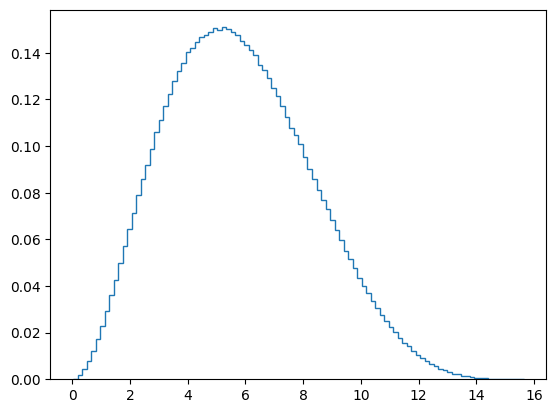

In [4]:
plt.hist(sampled_velocities[sampled_velocities != 0] * code_units.code_velocity.to(u.km/u.s), bins=100, density=True, histtype='step', label='sampled velocities');


<function matplotlib.pyplot.xlabel(xlabel: 'str', fontdict: 'dict[str, Any] | None' = None, labelpad: 'float | None' = None, *, loc: "Literal['left', 'center', 'right'] | None" = None, **kwargs) -> 'Text'>

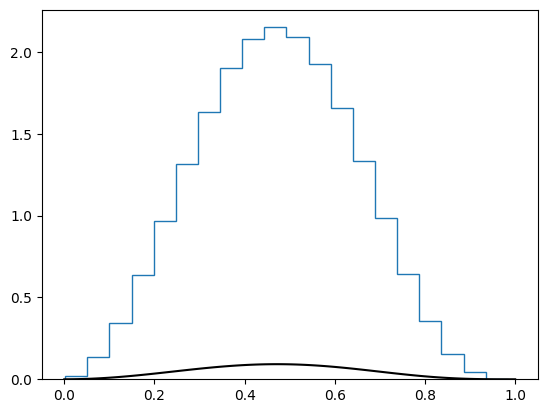

In [5]:
q = sampled_velocities/velocities_escape

plt.hist(q[q!=0], bins=20, density=True, histtype='step', label='sampled velociqies / escape velocity');
plt.plot(jnp.linspace(0, 1, 100), g(jnp.linspace(0, 1, 100)), label='g(q)', color='black')
plt.xlabel

In [6]:
config = SimulationConfig(N_particles=1_000_000, 
                          return_snapshots=True, 
                          num_snapshots=100, 
                          num_timesteps=10_000, 
                          external_accelerations=(LOGARITHMIC_POTENTIAL,), 
                          acceleration_scheme = DIRECT_ACC_MATRIX,
                          softening=(1 * u.pc).to(code_units.code_length).value) #default values

params = SimulationParams(t_end = (10 * u.Gyr).to(code_units.code_time).value,  
                          Plummer_params= PlummerParams(Mtot=(2.5*1e5 * u.Msun).to(code_units.code_mass).value,
                                                        a=(8 * u.pc).to(code_units.code_length).value),
                          Logarithmic_Params = LogarithmicParams(v0 = (220 * u.km / u.s).to(code_units.code_velocity).value,
                                                                q = 0.9,),
                          G=G, ) 

print(config)
print(params)

SimulationConfig(N_particles=1000000, dimensions=3, return_snapshots=True, num_snapshots=100, fixed_timestep=True, num_timesteps=10000, softening=np.float64(0.00010000000000000002), integrator=0, diffrax_solver=0, acceleration_scheme=2, batch_size=10000, double_map=False, external_accelerations=(4,), differentation_mode=1, num_checkpoints=100)
SimulationParams(G=1, t_end=np.float64(0.21209672678920705), Plummer_params=PlummerParams(a=np.float64(0.0008000000000000001), Mtot=np.float64(2.5)), NFW_params=NFWParams(Mvir=162000000000.0, r_s=15.3, c=10, d_c=1.4888043637074615), PointMass_params=PointMassParams(M=1.0), MN_params=MNParams(M=65000000000.0, a=3.0, b=0.28), PSP_params=PSPParams(alpha=-1.8, r_c=1.9), Logarithmic_Params=LogarithmicParams(v0=np.float64(1060.821068368804), q=0.9))


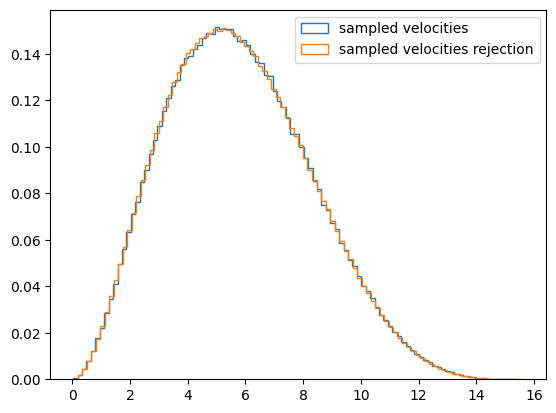

In [7]:
positions, velocities, mass = Plummer_sphere(key=random.PRNGKey(0), params=params, config=config)
plt.hist(jnp.linalg.norm(velocities, axis=1)*code_units.code_velocity.to(u.km/u.s) , bins=100, density=True, histtype='step', label='sampled velocities');
plt.hist(sampled_velocities[sampled_velocities != 0] * code_units.code_velocity.to(u.km/u.s), bins=100, density=True, histtype='step', label='sampled velocities rejection');
plt.legend()
